In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from expertise.data import load_all_predictors, load_feature_data
from expertise.predictors import train_boosted, create_predicted_dataframe, train_regression_tree, predict_aggregate, train_random_predictor
from expertise.multical import assess_callibration
from expertise.utils import subsample_rows

/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup Data

In [4]:
max_depth = 5
bins = 10

In [5]:
tidy = load_all_predictors()

In [6]:
x_train, y_train, x_train_id, x_test, y_test, x_test_id = load_feature_data()
test_predictions = train_boosted(x_train,y_train,x_test,max_depth)
m = create_predicted_dataframe(test_predictions,x_test_id,bins)
tidy = tidy.merge(m, on='file_id', how='left')

LS:  35%|███▌       35/100 00:16, Training Error=0.0085220

Early Termination at round: 36
Memory released!


In [40]:
tidy['boosted_pred'] = tidy['mc_pred'].round()


In [39]:
tidy

,file_id,human.pred.c,human.pred.t12,human.pred.t4,human.pred.t8,pred_esc_random_forest,true_esc,pred_esc_naive bayes,pred_esc_logistic_regression,pred_esc_linear_svm,...,rt_3,rt_4,rt_5,rt_6,rt_7,rt_8,rt_9,rt_10,cluster,boosted_pred
0,321932871341684,1,1,1,1,0,0,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
1,321933198008318,1,1,0,1,1,1,1,0,0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0
2,324207107780927,1,0,0,0,1,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
3,338180983050206,1,0,0,0,1,0,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0
4,338181036383534,0,1,1,0,1,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,1036634413051119,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
856,1036635499717677,0,1,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
857,1038831612831399,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
858,1038833189497908,1,1,0,0,1,0,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0


## Accuracy of Different Predictors

In [41]:
rf = assess_callibration(tidy,"pred_esc_random_forest","pred_esc_random_forest","true_esc")
lr = assess_callibration(tidy,"pred_esc_logistic_regression","pred_esc_logistic_regression","true_esc")
svm = assess_callibration(tidy,"pred_esc_linear_svm","pred_esc_linear_svm","true_esc")
gb = assess_callibration(tidy,"pred_esc_gradient_boosting","pred_esc_gradient_boosting","true_esc")
boosted = assess_callibration(tidy,"boosted_pred","boosted_pred","true_esc")
rf,lr,svm,gb,boosted

(0.686046511627907,
 0.6813953488372093,
 0.6976744186046512,
 0.6976744186046512,
 0.6953488372093023)

In [42]:
rf = assess_callibration(tidy,"human.pred.t12","pred_esc_random_forest","true_esc")
lr = assess_callibration(tidy,"human.pred.t12","pred_esc_logistic_regression","true_esc")
svm = assess_callibration(tidy,"human.pred.t12","pred_esc_linear_svm","true_esc")
gb = assess_callibration(tidy,"human.pred.t12","pred_esc_gradient_boosting","true_esc")
boosted = assess_callibration(tidy,"human.pred.t12","boosted_pred","true_esc")
rf,lr,svm,gb,boosted

(0.7255813953488373,
 0.7186046511627906,
 0.7255813953488373,
 0.7395348837209301,
 0.7209302325581395)

## Compare \mathcal{F}

In [8]:
boosted_predictor = assess_callibration(tidy,"human.pred.t12","bin","true_esc")
boosted_predictor

On val 0
On val 1
On val 10
On val 9


0.7209302325581396

In [9]:
num_trees = 10
num_clusters = 2
for i in range(1,num_trees+1):
    tidy['rt_{}'.format(i)] = subsample_rows(train_regression_tree(x_train,y_train,x_test,i),tidy,x_test_id)
tidy['cluster'] = predict_aggregate(tidy[['rt_{}'.format(i) for i in range(1,num_trees+1)]].to_numpy(),num_clusters)

In [10]:
top_k_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
top_k_predictor

On val 0
On val 1


0.6767441860465115

In [11]:
pred_by_trees = []
for num_trees in range(2,11):
    num_clusters = 2
    for i in range(1,num_trees+1):
        tidy['rt_{}'.format(i)] = subsample_rows(train_regression_tree(x_train,y_train,x_test,i),tidy,x_test_id)
    tidy['cluster'] = predict_aggregate(tidy[['rt_{}'.format(i) for i in range(1,num_trees+1)]].to_numpy(),num_clusters)
    top_k_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
    pred_by_trees.append(top_k_predictor)

On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1


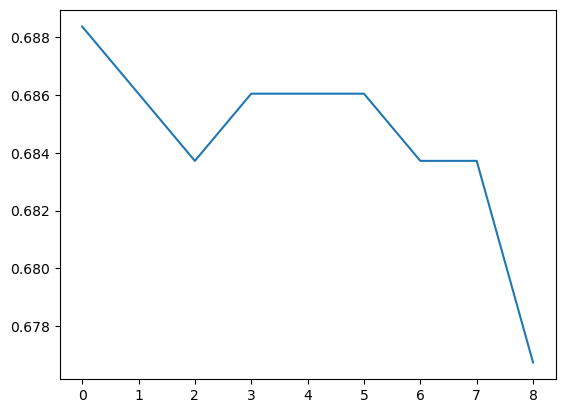

In [12]:
plt.plot(pred_by_trees)

In [13]:
individual_tree_perf = assess_callibration(tidy,"rt_1","rt_1","true_esc")
bagged_trees_perf = assess_callibration(tidy,"cluster","cluster","true_esc")
boosted_trees_perf = assess_callibration(tidy,"boosted_pred","boosted_pred","true_esc")
individual_tree_perf,bagged_trees_perf, boosted_trees_perf

On val 0.0
On val 1.0
On val 0
On val 1
On val 0.0
On val 1.0


(0.6813953488372093, 0.6581395348837209, 0.6953488372093023)

In [14]:
assess_callibration(tidy,"human.pred.t12","boosted_pred","true_esc")


On val 0.0
On val 1.0


0.7209302325581395

## Impact of Multicallibration

In [15]:
tidy['cluster'] = train_random_predictor(tidy['true_esc'],0.7)
random_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
random_predictor

On val 0
On val 1


0.7627906976744185

On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
O

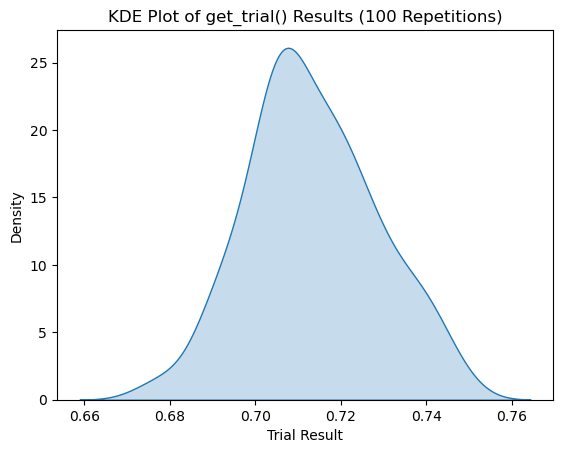

In [16]:
num_trials = 100
accuracy = 0.65
trials = []
for i in range(num_trials):
    tidy['cluster'] = train_random_predictor(tidy['true_esc'],accuracy)
    random_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
    trials.append(random_predictor)
sns.kdeplot(trials, shade=True)
plt.xlabel('Trial Result')
plt.ylabel('Density')
plt.title('KDE Plot of get_trial() Results (100 Repetitions)')
plt.show()

On val 0
On val 1
On val 0
On val 1


On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
On val 1
On val 0
O

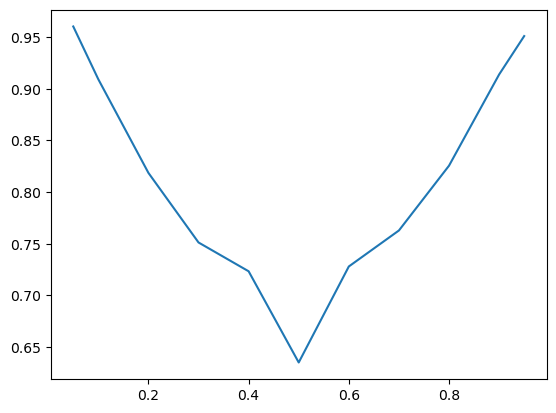

In [17]:
num_trials = 10
x_values = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
y_values = []
for accuracy in x_values:
    trials = []
    for i in range(num_trials):
        tidy['cluster'] = train_random_predictor(tidy['true_esc'],accuracy)
        random_predictor = assess_callibration(tidy,"human.pred.t12","cluster","true_esc")
        trials.append(random_predictor)
    y_values.append(np.max(trials))

plt.plot(x_values,y_values)

In [23]:
import pandas as pd
pd.crosstab(tidy['true_esc'],tidy['human.pred.t12'])

human.pred.t12,0,1
true_esc,,
0,344,212
1,69,235


In [34]:
data_column = tidy[['human.pred.t12','true_esc']].to_numpy()
new_labels = []
num_mistakes = 0
max_mistakes = int(len(tidy)*0.7)
for i in range(len(data_column)):
    if data_column[i][1] == 1:
        new_labels.append(1)
    elif data_column[i][1] == 0 and data_column[i][0] == 0 and num_mistakes<max_mistakes:
        new_labels.append(1)
    else:
        new_labels.append(0)
tidy['cluster'] = new_labels
assess_callibration(tidy,"human.pred.t12","cluster","true_esc")

0.9046511627906977

In [35]:
num_trials = 100
accuracy = 0.7
trials = []
for i in range(num_trials):
    tidy['cluster'] = train_random_predictor(tidy['true_esc'],accuracy)
    predictors_by_human = [assess_callibration(tidy,"human.pred.t{}".format(i),"cluster","true_esc") for i in [4,8,12]]
    trials.append(predictors_by_human)
trials = np.array(trials)

In [94]:
np.argmax(trials[:,0]),np.argmax(trials[:,1]),np.argmax(trials[:,2])

(62, 35, 62)

In [99]:
np.corrcoef(trials[:,0],trials[:,1])[0,1],np.corrcoef(trials[:,0],trials[:,2])[0,1],np.corrcoef(trials[:,1],trials[:,2])[0,1]

(0.5507097305367171, 0.509824906737115, 0.5345193427372451)

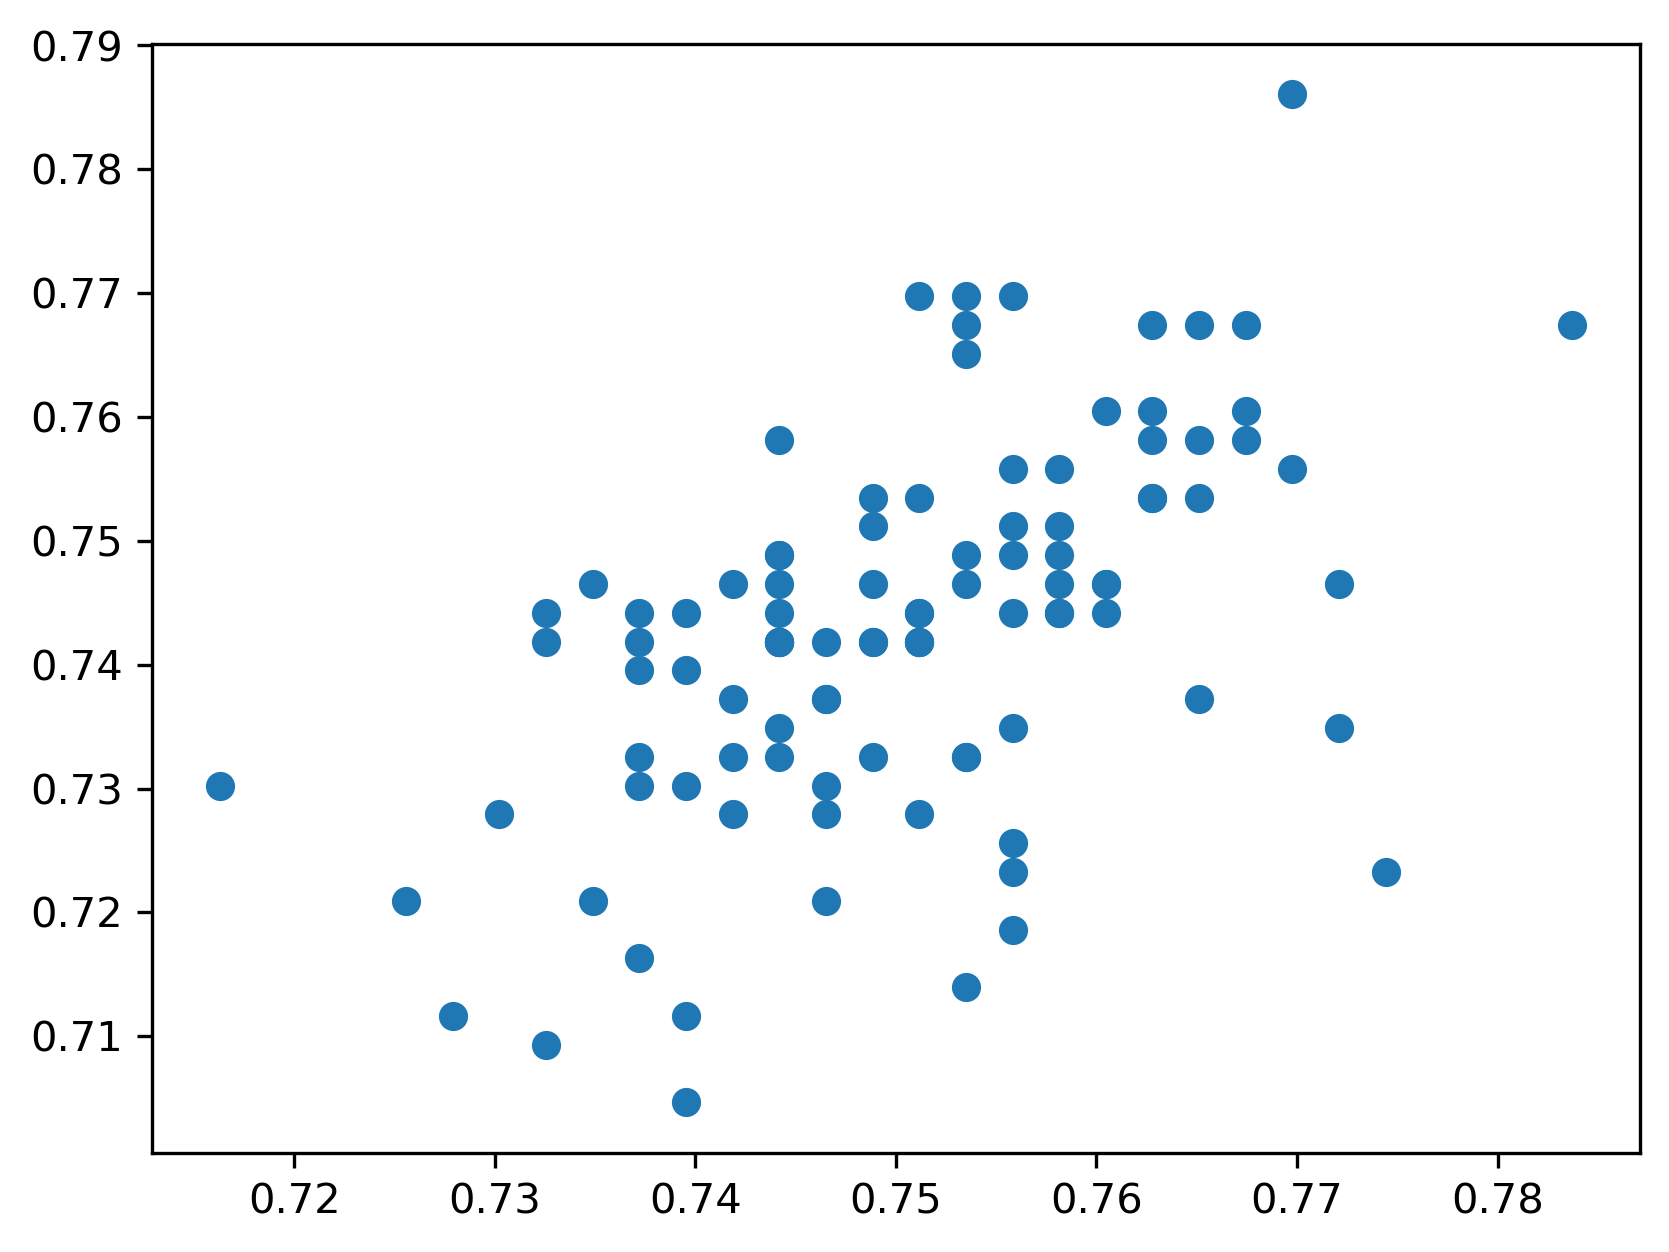

In [100]:
plt.scatter(trials[:,1],trials[:,2])